# Data preprocessing Part II

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = './data' #You many change the directory

challenge_transactions = pd.read_csv('{}/challenge_transactions.csv.gz'.format(DATA_DIR))
documents = pd.read_csv('{}/documents.csv.gz'.format(DATA_DIR))
feedback = pd.read_csv('{}/feedback.csv.gz'.format(DATA_DIR))
learn_sessions_transactions = pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))
topic_trees = pd.read_csv('{}/topic_trees.csv.gz'.format(DATA_DIR))
topics_translated = pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [2]:
def remove_users(events, transactions):
    tokens_event = set(events['transaction_token'].unique())
    print("{} tokens in events".format(len(tokens_event)))

    tokens_trans = set(transactions['transaction_token'].unique())
    print("{} tokens in transactions".format(len(tokens_trans)))

    missing_tokens = list(tokens_event - tokens_trans)
    missing_tokens.remove(np.nan)
    print("{} tokens in events but not in transactions".format(len(missing_tokens)))

    users_missing = list(events[events['transaction_token'].isin(missing_tokens)]['user_id'].unique())
    print("{} users in events but not in transactions".format(len(users_missing)))

    # Events without missing users. Equivalent to removing the missing tokens from events.
    len_events = len(events)
    events = events[~events['user_id'].isin(users_missing)]
    stat_events = (len_events - len(events))/len_events
    print("{}% of events eliminated".format(round(stat_events, 4)))

    return events, transactions
events, transactions = remove_users(events, transactions)

637678 tokens in events
800018 tokens in transactions
37685 tokens in events but not in transactions
1304 users in events but not in transactions
0.0595% of events eliminated


Merging learn_sessions_transactions dataframe with transactions dataframe:

In [3]:
df = transactions.merge(learn_sessions_transactions, on = 'transaction_id')

# Printing the original shape of the data
print("Original shape of the data: ", df.shape)

df.head()

Original shape of the data:  (497263, 19)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type,learn_session_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,SKIP,NaN,NaN,111059,3250,5,0,1,NaN
1,563378,b5978bb1-c34f-4157-9d1f-052b451edab5,387604.0,1aRVNzqunJs6eJCo9vZiy3,70675,NaN,NaN,1615192571101,NaN,unknown,NaN,NaN,NaN,14120,3,5,1,1,1.0
2,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,NaN,NaN,NaN,70380,3,5,1,2,NaN
3,774545,64645a54-a4f3-4e7b-9f88-39205882d87d,387604.0,1eWCmfpLnkQ96qFQp5XixR,95079,NaN,NaN,1630399544151,1.630400e+12,unknown,SKIP,NaN,NaN,41166,3119,5,1,1,1.0
4,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,NaN,NaN,NaN,44450,3119,5,1,2,NaN


### Cleaning criteria 1
Removing inactive students: those who did not perform any level check.
Justification of the cleaning decision: our goal is to predict user's success in level checks based on their regularity in time. As a consequence, we are not interested in users who did not perform any level check.

Computing the number of checks performed by each user on the platform:

In [4]:
test_data = pd.DataFrame(df.groupby(['user_id', 'learn_session_id', 'type_id']).size())
test_data = test_data.reset_index()
test_data = test_data[test_data['type_id'] == 2]
test_data = test_data.rename(columns = {0 : "num_checks"}, errors = "raise")
test_data = test_data.drop(columns = ['type_id'])
test_data.head()

,user_id,learn_session_id,num_checks
6,387604.0,41319,4
8,387604.0,44450,1
9,387604.0,49468,1
10,387604.0,49471,1
11,387604.0,70380,1


Merging df with test_data:

In [5]:
df = df.merge(test_data, on = ['user_id', 'learn_session_id'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type,learn_session_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted,num_checks
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,NaN,NaN,NaN,70380,3,5,1,2,NaN,1
1,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,NaN,NaN,NaN,44450,3119,5,1,2,NaN,1
2,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,SKIP,NaN,NaN,84083,3,5,1,2,NaN,2
3,1219465,779bba4c-ff28-40df-8d30-2d4ea4a45cc5,387604.0,8PbBly3e13M739zExxyczD,108046,NaN,NaN,1639411238461,NaN,unknown,NaN,NaN,NaN,84083,3,5,1,2,NaN,2
4,775986,4e3037c7-2597-4c44-808f-6f68963a6e1a,387604.0,2P5i2sCDZuoarjyFyM6F1n,87512,NaN,NaN,1630481009625,1.630481e+12,unknown,SKIP,NaN,NaN,41319,3,5,1,2,NaN,4


Histogram of the number of *level checks* performed by the users of the platform:

<AxesSubplot:title={'center':'Histogram of Level Checks'}, ylabel='Frequency'>

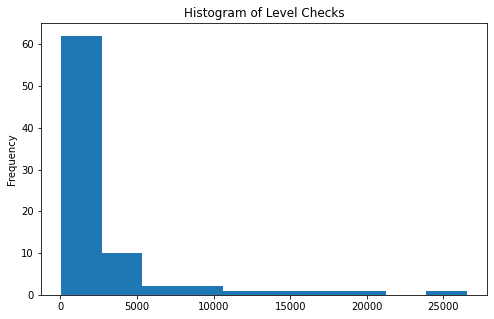

In [6]:
num_checks = df['num_checks'].value_counts(dropna=False)
num_checks.plot(
   kind="hist",
   figsize=(8,5),
   title = "Histogram of Level Checks"
)

Removing users who have not performed any level check:

In [7]:
# Printing the shape of the framework before the cleaning process:
print("Shape before cleaning: ", df.shape)

# Cleaning the data...
df = df[df['num_checks'] > 0]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (197542, 20)
Shape after cleaning:  (197542, 20)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,validation,solution,type,learn_session_id,topic_id,max_num_tasks,is_closed,type_id,is_accepted,num_checks
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,NaN,NaN,NaN,70380,3,5,1,2,NaN,1
1,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,NaN,NaN,NaN,44450,3119,5,1,2,NaN,1
2,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,SKIP,NaN,NaN,84083,3,5,1,2,NaN,2
3,1219465,779bba4c-ff28-40df-8d30-2d4ea4a45cc5,387604.0,8PbBly3e13M739zExxyczD,108046,NaN,NaN,1639411238461,NaN,unknown,NaN,NaN,NaN,84083,3,5,1,2,NaN,2
4,775986,4e3037c7-2597-4c44-808f-6f68963a6e1a,387604.0,2P5i2sCDZuoarjyFyM6F1n,87512,NaN,NaN,1630481009625,1.630481e+12,unknown,SKIP,NaN,NaN,41319,3,5,1,2,NaN,4


### Cleaning criteria 2
Removing untrackable students: those who never did any training question or theory reading.
Justification of the cleaning decision: our goal is to predict user's success in level checks based on their regularity in time. As a consequence, we are not interested in users that have not perform any training or preparation for the level checks because we cannot measure their regularity (since they have not used the platform).

Merging df with events:

In [8]:
df = df.merge(events, on = ['transaction_token', 'user_id'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,type_id,is_accepted,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2,NaN,1,1551821,1637146635291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2,NaN,1,1551834,1637146648711,SESSION,CLOSE,CLICK,70380.0,NaN
2,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,2,NaN,1,368387,1631200106259,SESSION,REVIEW_TASK,VIEW,44450.0,NaN
3,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,2,NaN,1,368388,1631200111299,SESSION,CLOSE,CLICK,44450.0,NaN
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,2,NaN,2,2164574,1639411227584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN


Computing the number of questions submitted by each user on the platform:

In [9]:
test_data = pd.DataFrame(df.groupby(['user_id', 'action']).size())
test_data = test_data.reset_index()
test_data = test_data[test_data['action'] == ('SUBMIT_ANSWER' or 'GO_TO_THEORY')]
test_data = test_data.rename(columns = {0 : "num_participations"}, errors = "raise")
test_data = test_data.drop(columns = ['action'])
test_data.head()

,user_id,num_participations
3,387604.0,1
6,387605.0,29
9,387608.0,23
12,387644.0,12
17,387712.0,20


Merging df with test_data:

In [10]:
df = df.merge(test_data, on = 'user_id')
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,is_accepted,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,NaN,1,1551821,1637146635291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,NaN,1,1551834,1637146648711,SESSION,CLOSE,CLICK,70380.0,NaN,1
2,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,NaN,1,368387,1631200106259,SESSION,REVIEW_TASK,VIEW,44450.0,NaN,1
3,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,NaN,1,368388,1631200111299,SESSION,CLOSE,CLICK,44450.0,NaN,1
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,NaN,2,2164574,1639411227584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1


Histogram of the number of *participations* performed by the users of the platform:

<AxesSubplot:title={'center':'Histogram of Participations'}, ylabel='Frequency'>

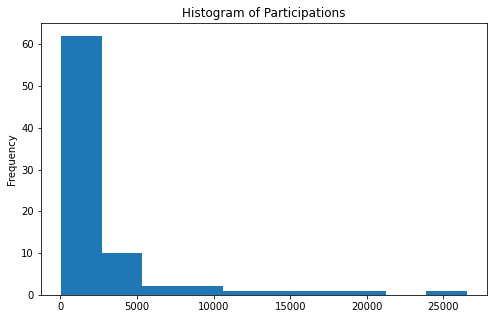

In [11]:
num_participations = df['num_participations'].value_counts(dropna=False)
num_checks.plot(
   kind="hist",
   figsize=(8,5),
   title = "Histogram of Participations"
)

Removing users who have never performed a training question or have not read any theory on the platform:

In [12]:
# Printing the shape of the framework before the cleaning process:
print("Shape before cleaning: ", df.shape)

# Cleaning the data...
df = df[df['num_participations'] > 0]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (334488, 28)
Shape after cleaning:  (334488, 28)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,is_accepted,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,NaN,1,1551821,1637146635291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,NaN,1,1551834,1637146648711,SESSION,CLOSE,CLICK,70380.0,NaN,1
2,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,NaN,1,368387,1631200106259,SESSION,REVIEW_TASK,VIEW,44450.0,NaN,1
3,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,NaN,1,368388,1631200111299,SESSION,CLOSE,CLICK,44450.0,NaN,1
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,NaN,2,2164574,1639411227584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1


### Cleaning criteria 3
Removing inactive students: those who have less than $3$ weeks with at least $4$ actions of any type.

Adding `week_of_year` to the dataframe:

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 'ms')
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week_of_year
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1,1551821,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,46
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1,1551834,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,46
2,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,1,368387,2021-09-09 15:08:26.259,SESSION,REVIEW_TASK,VIEW,44450.0,NaN,1,36
3,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,1,368388,2021-09-09 15:08:31.299,SESSION,CLOSE,CLICK,44450.0,NaN,1,36
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,2,2164574,2021-12-13 16:00:27.584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1,50


Adding `week_min` to the dataframe:

In [14]:
test_data = df[['user_id', 'week_of_year']]
test_data = test_data.groupby(['user_id']).aggregate(lambda x: np.min(np.array(list(x)))).reset_index()
test_data = test_data.rename(columns = {"week_of_year" : "week_min"}, errors = "raise")
test_data.head()

,user_id,week_min
0,387604.0,35
1,387605.0,26
2,387608.0,6
3,387644.0,47
4,387712.0,47


Merging df with test_data:

In [15]:
df = df.merge(test_data, on = 'user_id')
df['week'] = df['week_of_year'] - df['week_min']
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week_of_year,week_min,week
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,46,35,11
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,46,35,11
2,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,2021-09-09 15:08:26.259,SESSION,REVIEW_TASK,VIEW,44450.0,NaN,1,36,35,1
3,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,2021-09-09 15:08:31.299,SESSION,CLOSE,CLICK,44450.0,NaN,1,36,35,1
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,2021-12-13 16:00:27.584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1,50,35,15


Dropping unnecessary columns:

In [16]:
df = df.drop(columns = ['week_of_year', 'week_min'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,num_checks,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1,1551821,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,11
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1,1551834,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,11
2,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,1,368387,2021-09-09 15:08:26.259,SESSION,REVIEW_TASK,VIEW,44450.0,NaN,1,1
3,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,1,368388,2021-09-09 15:08:31.299,SESSION,CLOSE,CLICK,44450.0,NaN,1,1
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,2,2164574,2021-12-13 16:00:27.584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1,15


Computing actions per week:

In [17]:
test_data = df.groupby(['user_id', 'week']).size()
test_data = pd.DataFrame(test_data)
test_data = test_data.reset_index()
test_data = test_data.rename(columns = {0 : "num_actions_per_week"}, errors = "raise")
test_data.head()

,user_id,week,num_actions_per_week
0,387604.0,0,9
1,387604.0,1,2
2,387604.0,3,5
3,387604.0,11,4
4,387604.0,15,4


Sorting the values of the dataframe `test_data`:

In [18]:
test_data = test_data.sort_values(['user_id', 'week'])
test_data.head()

,user_id,week,num_actions_per_week
0,387604.0,0,9
1,387604.0,1,2
2,387604.0,3,5
3,387604.0,11,4
4,387604.0,15,4


Merging df with test_data:

In [19]:
df = df.merge(test_data, on = ['user_id', 'week'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1551821,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,11,4
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1551834,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,11,4
2,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,1552316,2021-11-17 11:04:52.372,SESSION,REVIEW_TASK,VIEW,70395.0,NaN,1,11,4
3,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,1552364,2021-11-17 11:05:42.443,SESSION,CLOSE,CLICK,70395.0,NaN,1,11,4
4,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,368387,2021-09-09 15:08:26.259,SESSION,REVIEW_TASK,VIEW,44450.0,NaN,1,1,2


Now, I will summarize the data using a boxplot: 

<AxesSubplot:xlabel='num_actions_per_week'>

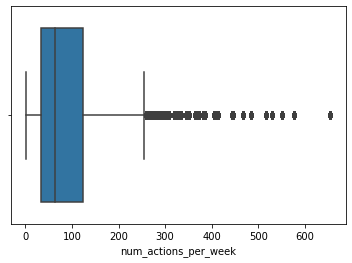

In [20]:
sns.boxplot(x = df['num_actions_per_week'])

We can appreciate in the boxplot the presence of outliers. I will proceed to detect the outliers using the IQR and to delect them:

In [21]:
# Calculating the first and third quartile and the Inter Quartile Range...
Q1 = np.percentile(df['num_actions_per_week'], 25, interpolation = 'midpoint')
Q3 = np.percentile(df['num_actions_per_week'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1

# Printing the shape of the framework before removing the ourliers:
print("Shape before cleaning: ", df.shape)

# Calculating the upper bound...
upper = np.where(df['num_actions_per_week'] >= (Q3+1.5*IQR))
# Calculating the lower bound
lower = np.where(df['num_actions_per_week'] <= (Q1-1.5*IQR))
 
# Removing the outliers:
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (334488, 30)
Shape after cleaning:  (313987, 30)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1551821,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,11,4
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1551834,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,11,4
2,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,1552316,2021-11-17 11:04:52.372,SESSION,REVIEW_TASK,VIEW,70395.0,NaN,1,11,4
3,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,1552364,2021-11-17 11:05:42.443,SESSION,CLOSE,CLICK,70395.0,NaN,1,11,4
4,803096,37f3ad9a-ca06-43dc-9878-90599ac31f44,387604.0,1LNLRvfltpl9kmi7YOJIKV,64911,NaN,NaN,1631200106071,NaN,unknown,...,368387,2021-09-09 15:08:26.259,SESSION,REVIEW_TASK,VIEW,44450.0,NaN,1,1,2


Now, I will check if the weeks of the users with less than $4$ activities of any kind performed where included in the outliers:

Deleting rows corresponding to weeks with less than $4$ activities performed:

In [22]:
# Printing the shape of the framework before the cleaning:
print("Shape before cleaning: ", df.shape)

# Cleaning process
df = df[df['num_actions_per_week'] >= 4]

# Printing the shape of the framework after the cleaning:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (313987, 30)
Shape after cleaning:  (312152, 30)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1551821,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,11,4
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,1551834,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,11,4
2,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,1552316,2021-11-17 11:04:52.372,SESSION,REVIEW_TASK,VIEW,70395.0,NaN,1,11,4
3,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,1552364,2021-11-17 11:05:42.443,SESSION,CLOSE,CLICK,70395.0,NaN,1,11,4
6,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,2164574,2021-12-13 16:00:27.584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1,15,4


In [23]:
df.tail()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,event_id,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week
334483,1584551,7c9956b4-d2e2-4f30-9245-8155d6636bd5,404604.0,9wGXbOQkPdV6yr6aUa4ubj,89818,NaN,NaN,1645454941994,1.645455e+12,unknown,...,3509238,2022-02-21 14:49:30.547,SESSION,SKIP,CLICK,112060.0,NaN,4,0,17
334484,1584578,7e328437-52df-4697-94e9-186844c3e269,404604.0,a1jzfZLIHDt7LzD8KKha54,39046,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""3""...",1645455097067,1.645455e+12,unknown,...,3509288,2022-02-21 14:51:37.334,SESSION,REVIEW_TASK,VIEW,112060.0,NaN,4,0,17
334485,1584578,7e328437-52df-4697-94e9-186844c3e269,404604.0,a1jzfZLIHDt7LzD8KKha54,39046,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""3""...",1645455097067,1.645455e+12,unknown,...,3509300,2022-02-21 14:52:16.634,TASK,SUBMIT_ANSWER,CLICK,112060.0,NaN,4,0,17
334486,1584584,48c02063-8c99-4e2c-b783-b626cf2fcfe9,404604.0,AUaU88i0ME6XdsMZWd5gp,39050,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1645455137205,1.645461e+12,unknown,...,3509301,2022-02-21 14:52:17.465,SESSION,REVIEW_TASK,VIEW,112060.0,NaN,4,0,17
334487,1584584,48c02063-8c99-4e2c-b783-b626cf2fcfe9,404604.0,AUaU88i0ME6XdsMZWd5gp,39050,PARTIAL,"{""type"": ""MULTIPLE_CHOICE"", ""selections"": {""0""...",1645455137205,1.645461e+12,unknown,...,3510838,2022-02-21 16:33:16.870,TASK,SUBMIT_ANSWER,CLICK,112060.0,NaN,4,0,17


*Definition:* A **significant week** of a particular user is a week in which that user has performed at least 4 actions of any type. Note that we have just deleted of our dataframe of the weeks that are not significant.

Computing the total number of weeks that each user has been actived in the platform:

In [24]:
test_data = df[['user_id', 'week']].drop_duplicates()
test_data.head()

,user_id,week
0,387604.0,11
6,387604.0,15
10,387604.0,0
19,387604.0,3
27,387605.0,1


In [25]:
test_data = pd.DataFrame(test_data.groupby(['user_id']).size()).reset_index()
test_data = test_data.rename(columns = {0 : "num_weeks_per_user"}, errors = "raise")
test_data.head()

,user_id,num_weeks_per_user
0,387604.0,4
1,387605.0,2
2,387608.0,4
3,387644.0,1
4,387712.0,1


In [26]:
test_data.tail()

,user_id,num_weeks_per_user
4332,404583.0,1
4333,404585.0,1
4334,404586.0,1
4335,404592.0,1
4336,404604.0,1


Merging df with test_data:

In [27]:
df = df.merge(test_data, on = 'user_id')
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,11,4,4
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,11,4,4
2,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,2021-11-17 11:04:52.372,SESSION,REVIEW_TASK,VIEW,70395.0,NaN,1,11,4,4
3,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,2021-11-17 11:05:42.443,SESSION,CLOSE,CLICK,70395.0,NaN,1,11,4,4
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,2021-12-13 16:00:27.584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1,15,4,4


Now, I will summarize the data using a boxplot:

<AxesSubplot:xlabel='num_weeks_per_user'>

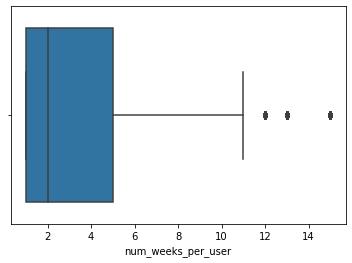

In [28]:
sns.boxplot(x = df['num_weeks_per_user'])

We can appreciate in the boxplot the presence of outliers. I will proceed to detect the outliers using the IQR and to delect them:

In [29]:
# Calculating the first and third quartile and the Inter Quartile Range...
Q1 = np.percentile(df['num_weeks_per_user'], 25, interpolation = 'midpoint')
Q3 = np.percentile(df['num_weeks_per_user'], 75, interpolation = 'midpoint')
IQR = Q3 - Q1

# Printing the shape of the framework before removing the ourliers:
print("Shape before cleaning: ", df.shape)

# Calculating the upper bound...
upper = np.where(df['num_weeks_per_user'] >= (Q3+1.5*IQR))
# Calculating the lower bound
lower = np.where(df['num_weeks_per_user'] <= (Q1-1.5*IQR))
 
# Removing the outliers:
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (312152, 31)
Shape after cleaning:  (296617, 31)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,11,4,4
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,11,4,4
2,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,2021-11-17 11:04:52.372,SESSION,REVIEW_TASK,VIEW,70395.0,NaN,1,11,4,4
3,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,2021-11-17 11:05:42.443,SESSION,CLOSE,CLICK,70395.0,NaN,1,11,4,4
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,2021-12-13 16:00:27.584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1,15,4,4


Now, I will check if the weeks of the users with less than $3$ **significant weeks** where included in the outliers:

Deleting rows corresponding to users with less than 3 significant weeks:

In [30]:
# Printing the shape of the framework before the cleaning:
print("Shape before cleaning: ", df.shape)

# Cleaning process...
df = df[df['num_weeks_per_user'] > 2]

# Printing the shape of the framework after the cleaning process:
print("Shape after cleaning: ", df.shape)
df.head()

Shape before cleaning:  (296617, 31)
Shape after cleaning:  (134451, 31)


,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
0,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2021-11-17 10:57:15.291,SESSION,REVIEW_TASK,VIEW,70380.0,NaN,1,11,4,4
1,1062011,411c11ae-6af2-4574-b7df-d94dac280da5,387604.0,1DI3PtzowVCafiuZCb0mEX,89020,NaN,NaN,1637146635218,NaN,unknown,...,2021-11-17 10:57:28.711,SESSION,CLOSE,CLICK,70380.0,NaN,1,11,4,4
2,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,2021-11-17 11:04:52.372,SESSION,REVIEW_TASK,VIEW,70395.0,NaN,1,11,4,4
3,1062122,38ec8cb3-bb73-496b-a324-040e1e60f1a2,387604.0,Y6X2CySYGr6cHodeQQnSx,85783,NaN,NaN,1637147092305,NaN,unknown,...,2021-11-17 11:05:42.443,SESSION,CLOSE,CLICK,70395.0,NaN,1,11,4,4
4,1219464,b4c967f7-e82d-4a33-a251-a6cb82b339e2,387604.0,2lr1bK6ZNm36FHHh1xWNL1,108050,NaN,NaN,1639411227473,1.639411e+12,unknown,...,2021-12-13 16:00:27.584,SESSION,REVIEW_TASK,VIEW,84083.0,NaN,1,15,4,4
